In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import time
from scipy import stats

In [86]:
def read_rama(path):
    with open(path, 'r') as file:
        phi = []
        psi = []
        for row in file:
            if row.split()[0] == '#':
                continue
            if row.split()[0] == '@': 
                continue
            if row.split()[0] == '@TYPE': 
                continue
            phi.append(float(row.split()[0])) 
            psi.append(float(row.split()[1]))

        df = pd.DataFrame(columns=['phi', 'psi'])
        df['phi'] = phi
        df['psi'] = psi
        df['weight'] = 1 / len(df.index)
        #df['weight_psi'] = 1 / len(df.index)

    return df

####################################################################################################

def make_weights(rama_df, dih, const, mult, beta):
        
    rama_df = rama_df.assign(weight=lambda x: weight(x.phi, x.psi, dih, const, mult, beta))
    #rama_df = rama_df.assign(weight_psi=lambda x: weight_psi(x.psi, dih, const, mult, beta))


    rama_df['weight'] = rama_df['weight'] / np.sum(rama_df['weight'])
    #rama_df['weight_psi'] = rama_df['weight_psi'] / np.sum(rama_df['weight_psi'])
    return rama_df

####################################################################################################

def weight(phi, psi, dih, const, mult, beta):

    d2r = np.pi

    gd_42 = (const[0] * ( 1 + np.cos(mult[0] * (psi * d2r) - (dih[0] * d2r))))
    gd_43 = (const[1] * ( 1 + np.cos(mult[1] * (phi * d2r) - (dih[1] * d2r))))        
    gd_44 = (const[2] * ( 1 + np.cos(mult[2] * (phi * d2r) - (dih[2] * d2r))))
    gd_45 = (const[3] * ( 1 + np.cos(mult[3] * (psi * d2r) - (dih[3] * d2r))))

    return np.exp(-1 * beta * (gd_42 + gd_43 + gd_44 + gd_45))

####################################################################################################

def make_matrix(df, positions, dimension, bw):

    values = np.vstack([df['phi'], df['psi']])

    kernel = stats.gaussian_kde(values, bw_method = bw, weights=df['weight'])

    mat = np.reshape(kernel(positions).T, dimension)
    #print(mat)  
    return mat

###################################################################################################

def make_grid():
    X, Y = np.mgrid[-180:180:72j, -180:180:72j]

    positions = np.vstack([X.ravel(), Y.ravel()])

    dimension = X.shape

    return positions, dimension


In [99]:
dih = [94.624, 173.689, 170.735, -149.013]
const = [2.1078, 0.1435, 2.9852, 1.4036]
mult = [5,5,3,3]

In [101]:
amber_mat = make_matrix(read_rama('amber_rama/rama_aladp_amber.xvg'), positions, dimension, 0.5)
greta_df = read_rama('greta_rama/rama_aladp_greta_mod1.xvg')
greta_mat = make_matrix(greta_df, positions, dimension, 0.5)
greta_df_rw = make_weights(greta_df, dih, const, mult, beta=1/2.4943389)
greta_mat_rw = make_matrix(greta_df_rw, positions, dimension, 0.5)

In [94]:
#greta_df_2 = read_rama('greta_rama/rama_aladp_greta_mod1.xvg')
#greta_mat_2 = make_matrix(greta_df_2, positions, dimension, 0.5)

Text(0.5, 1.0, 'ALA - Previous Best Guess')

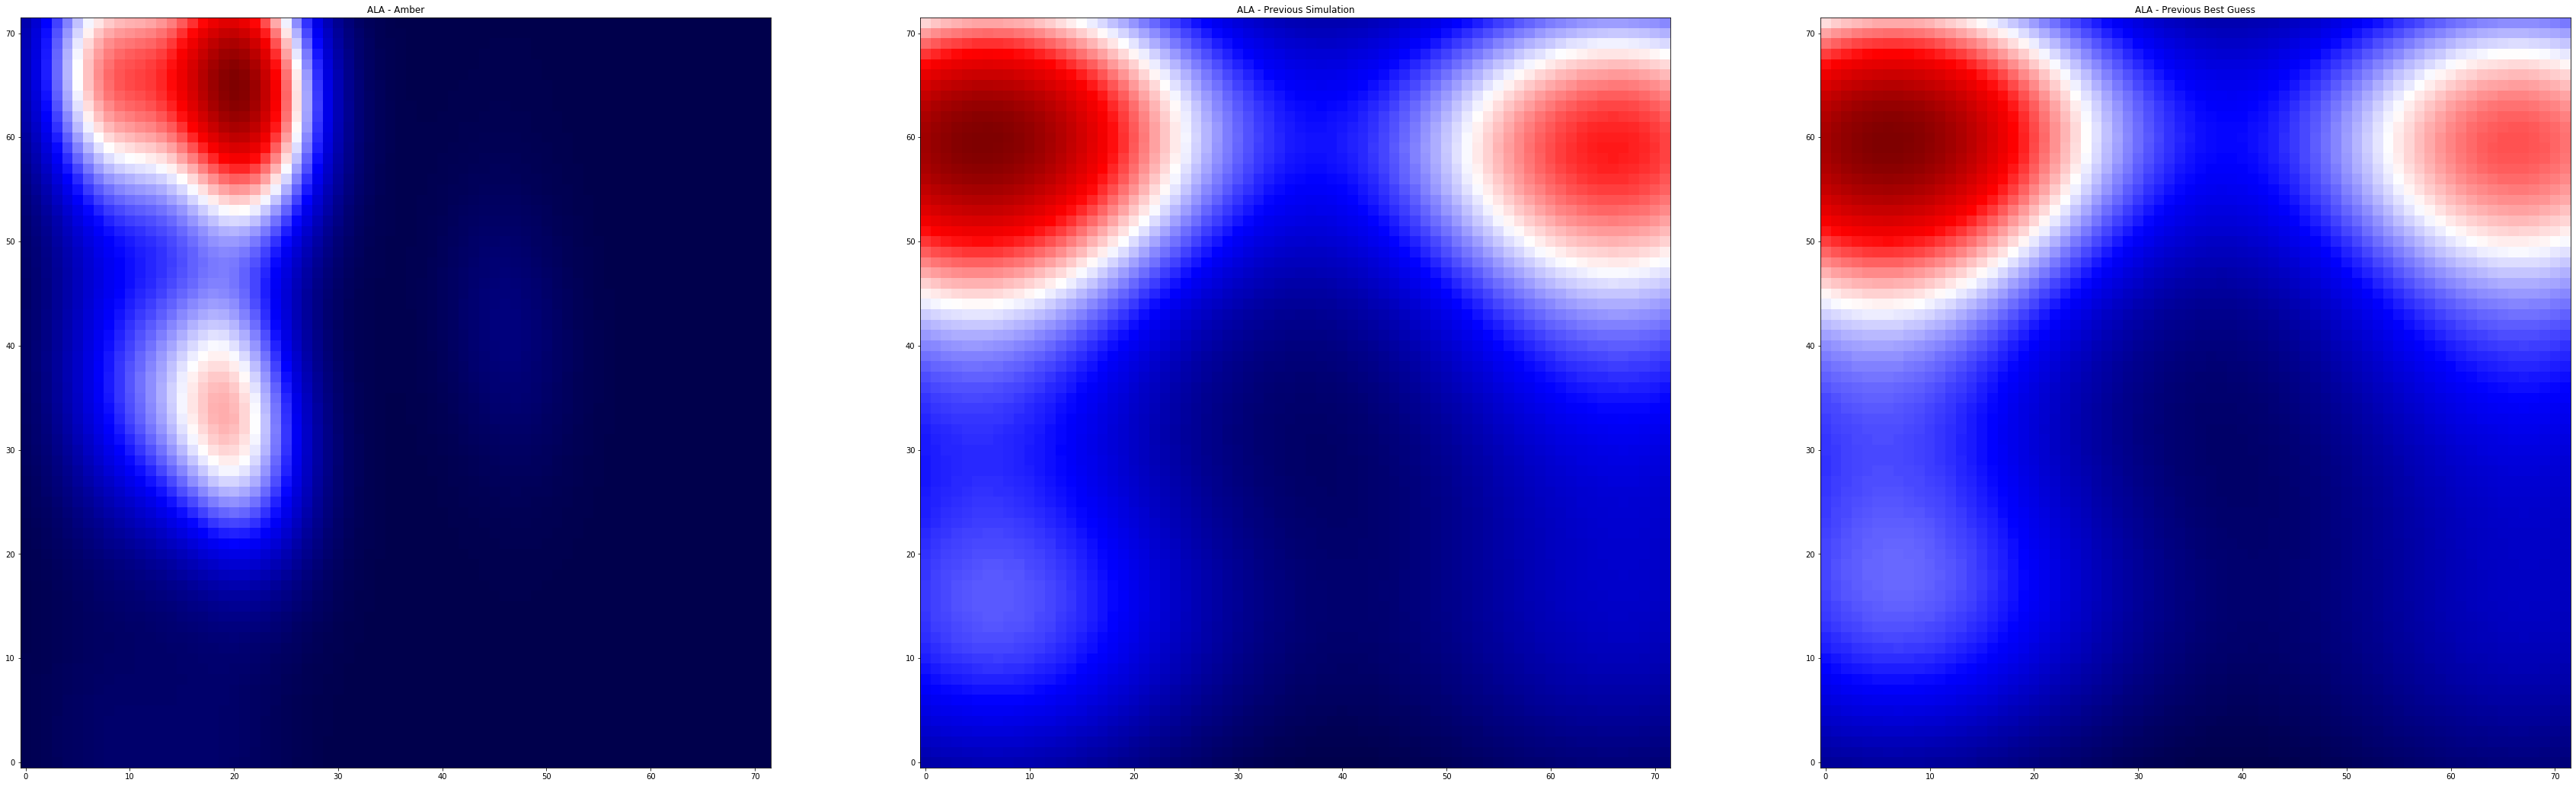

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(60,60))

ax1.imshow((amber_mat).T, interpolation='nearest', origin='low', cmap='seismic')
ax1.set_title('ALA - Amber')
ax2.imshow((greta_mat).T, interpolation='nearest', origin='low', cmap='seismic')
ax2.set_title('ALA - Previous Simulation')
ax3.imshow((greta_mat_rw).T, interpolation='nearest', origin='low', cmap='seismic')
ax3.set_title('ALA - Previous Best Guess')
#ax4.imshow((greta_mat_2).T, interpolation='nearest', origin='low', cmap='seismic')
#ax4.set_title('ALA - Simulation of Best Guess')
#plt.savefig('plots/ALA_run1')
#BW = 0.5